In [1]:
!pip -q install gymnasium==0.29.1 gymnasium[classic-control]
!pip install stable-baselines3[extra]==2.3.0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached stable_baselines3-2.3.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)


ERROR: Could not find a version that satisfies the requirement ale-py~=0.8.1; extra == "atari" (from shimmy[atari]) (from versions: 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.1, 0.11.2)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for ale-py~=0.8.1; extra == "atari"


In [2]:
from __future__ import annotations
from dataclasses import dataclass
import math
import numpy as np
import matplotlib.pyplot as plt

Diamêtro do Talhão: 115.00 m
Área do Talhão:     10,386.9 m²  (1.039 ha)
Comprimento do Braço Pivot:   57.50 m


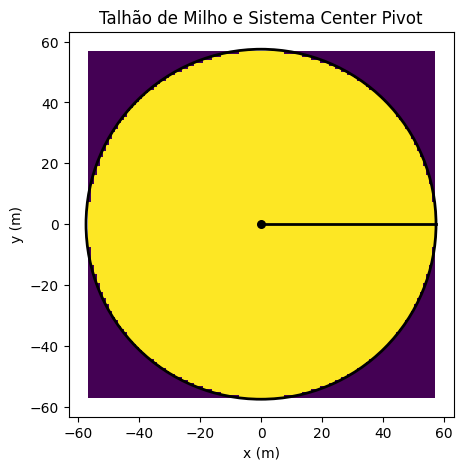

In [3]:
HA_IN_M2 = 10_000.0

def diameter_for_area_m2(area_m2: float) -> float:
    """Return the diameter of a circle with the given area (in m²)."""
    r = math.sqrt(area_m2 / math.pi)
    return 2 * r

def area_for_diameter_m(diameter_m: float) -> float:
    """Return the area (m²) of a circle with the given diameter (m)."""
    r = diameter_m / 2.0
    return math.pi * r * r

@dataclass
class Field:
    """Circular field discretized into a raster mask for simulation."""
    diameter_m: float
    cell_size_m: float = 1.0  # grid resolution (1 m cells by default)

    def __post_init__(self):
        self.radius_m = self.diameter_m / 2.0
        self.area_m2 = area_for_diameter_m(self.diameter_m)
        self.area_ha = self.area_m2 / HA_IN_M2
        # Build a square grid that fully contains the circle
        side = int(math.ceil(self.diameter_m / self.cell_size_m))
        # Center the circle inside the grid
        self.origin_m = -0.5 * side * self.cell_size_m  # lower-left corner coord
        xs = np.linspace(self.origin_m + 0.5*self.cell_size_m,
                         -self.origin_m - 0.5*self.cell_size_m,
                         side)
        ys = xs.copy()
        self.X, self.Y = np.meshgrid(xs, ys)
        self.R = np.sqrt(self.X**2 + self.Y**2)
        # Mask for cells inside the circular field
        self.mask = self.R <= self.radius_m + 1e-9

        # (Optional) initialize soil moisture state (volumetric fraction)
        # We'll just create a placeholder array (e.g., uniform 0.20)
        self.soil_moisture = np.zeros_like(self.R, dtype=np.float32)
        self.soil_moisture[self.mask] = 0.20

    def plot(self, ax: plt.Axes | None = None, title: str = "") -> plt.Axes:
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 5))
        # Show the mask (field area)
        im = ax.imshow(self.mask.astype(float),
                       origin="lower",
                       extent=[self.X.min(), self.X.max(), self.Y.min(), self.Y.max()])
        # Draw the circle boundary for clarity
        circle = plt.Circle((0, 0), self.radius_m, fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(title or f"Field: D={self.diameter_m:.2f} m (~{self.area_ha:.3f} ha)")
        return ax

@dataclass
class CenterPivot:
    """Geometric representation of a center pivot arm (no control yet)."""
    radius_m: float              # arm length (to the last sprinkler)
    angle_rad: float = 0.0       # current angle (0 = along +x axis)
    angular_speed_rad_s: float = 0.0  # can be set later by PPO agent

    @classmethod
    def from_diameter(cls, diameter_m: float) -> "CenterPivot":
        return cls(radius_m=diameter_m / 2.0)

    def tip_position(self) -> tuple[float, float]:
        """(x, y) of the pivot tip at current angle."""
        return (self.radius_m * math.cos(self.angle_rad),
                self.radius_m * math.sin(self.angle_rad))

    def plot(self, ax: plt.Axes, color="k"):
        """Draw the pivot arm on an existing axes."""
        x_tip, y_tip = self.tip_position()
        ax.plot([0, x_tip], [0, y_tip], linewidth=2, color=color)
        ax.scatter([0], [0], s=30, color=color)  # pivot center

# --- Choose geometry ---------------------------------------------------------
USE_EXACT_1_HA = False  # set True if you prefer exactly 1 hectare

if USE_EXACT_1_HA:
    diameter_m = diameter_for_area_m2(HA_IN_M2)      # ~112.84 m
else:
    diameter_m = 115.0                               # your choice

pivot_length_m = diameter_m / 2.0  # by definition for a full circle
assert math.isclose(pivot_length_m, 57.5, rel_tol=0, abs_tol=1e-6) or not (diameter_m == 115.0)

# Build field and pivot
field = Field(diameter_m=diameter_m, cell_size_m=1.0)
pivot = CenterPivot.from_diameter(diameter_m)

print(f"Diamêtro do Talhão: {field.diameter_m:.2f} m")
print(f"Área do Talhão:     {field.area_m2:,.1f} m²  ({field.area_ha:.3f} ha)")
print(f"Comprimento do Braço Pivot:   {pivot.radius_m:.2f} m")

# Quick visualization (optional)
ax = field.plot(title="Talhão de Milho e Sistema Center Pivot")
pivot.plot(ax)
plt.show()

In [4]:
!pip install gymnasium
import math
import gymnasium as gym
import numpy as np
from gymnasium import spaces


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [5]:
class PivotIrrigationEnv(gym.Env):
    """
    Simple center-pivot irrigation environment.
    Actions: [angular_speed_cmd, water_rate_cmd] in [-1, 1]
      - angular_speed_cmd -> rad/s in [-w_max, +w_max]
      - water_rate_cmd    -> mm/h in [0, rate_max]
    Observations (R^6):
      [mean_m, std_m, min_m, max_m, sin(theta), cos(theta)]
    Goal: keep soil moisture near target band while minimizing water use.
    """
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self,
                 field: Field,
                 pivot: CenterPivot,
                 dt_s: float = 10.0,           # simulation step (seconds)
                 w_max_rad_s: float = 0.003,   # ~0.17 deg/s (slow pivot)
                 rate_max_mm_h: float = 40.0,  # max application rate (mm/hour)
                 target_m: float = 0.23,       # target volumetric moisture
                 band_m: float = 0.04,         # ± band around target
                 et_mm_h: float = 0.5          # evapotranspiration loss (mm/h)
                 ):
        super().__init__()
        self.base_field = field
        self.base_pivot = pivot
        self.dt_s = dt_s
        self.w_max = w_max_rad_s
        self.rate_max = rate_max_mm_h
        self.target = target_m
        self.band = band_m
        self.et_mm_h = et_mm_h

        # Action: 2D continuous in [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)

        # Observation: compact summary + pivot orientation (sin, cos)
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0, 0.0, -1.0, -1.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0, 1.0,  1.0,  1.0], dtype=np.float32),
            shape=(6,),
            dtype=np.float32
        )

        # Internal state (cloned per episode)
        self.field = None
        self.pivot = None
        self.t = 0.0
        self.episode_len = int((3600 * 6) / dt_s)  # 6 hours by default

    # --- Helpers -------------------------------------------------------------
    def _clone_primitives(self):
        # Shallow clone Field geometry, new soil array
        f = Field(diameter_m=self.base_field.diameter_m, cell_size_m=self.base_field.cell_size_m)
        f.soil_moisture[:] = self.base_field.soil_moisture  # copy initial moisture
        p = CenterPivot(radius_m=self.base_pivot.radius_m,
                        angle_rad=0.0, angular_speed_rad_s=0.0)
        return f, p

    def _apply_irrigation(self, rate_mm_h: float):
        """Deposit water along the pivot arm (a thin swath)."""
        if rate_mm_h <= 0:
            return
        # Convert rate to mm over this dt
        mm_this_step = rate_mm_h * (self.dt_s / 3600.0)

        # We irrigate cells close to the arm line from (0,0) to tip at angle.
        # Approximate by a distance-to-line threshold (swath width).
        x_tip, y_tip = self.pivot.tip_position()
        X, Y = self.field.X, self.field.Y

        # Distance from each cell center to the arm segment
        # Segment P0=(0,0), P1=(x_tip, y_tip)
        P0x, P0y = 0.0, 0.0
        P1x, P1y = x_tip, y_tip
        # vector P0->P1
        vx, vy = P1x - P0x, P1y - P0y
        v2 = vx*vx + vy*vy + 1e-12
        # projection of P0->cell onto v
        wx, wy = X - P0x, Y - P0y
        t = (wx*vx + wy*vy) / v2
        t = np.clip(t, 0.0, 1.0)
        # closest point on segment
        cx = P0x + t*vx
        cy = P0y + t*vy
        # distance to line
        dist = np.hypot(X - cx, Y - cy)

        # Define a swath ~ 3 meters wide around the arm
        swath_m = 3.0
        mask_swath = (dist <= swath_m) & self.field.mask

        # Simple depth-to-moisture conversion:
        # Assume 1 mm = 1 liter/m²; convert to volumetric Δθ with an effective root zone depth.
        root_zone_m = 0.30  # 30 cm
        # volumetric fraction increase = water_depth(m) / root_zone_m
        dtheta = (mm_this_step / 1000.0) / root_zone_m

        self.field.soil_moisture[mask_swath] += dtheta

    def _apply_et(self):
        """Evapotranspiration removes water uniformly (very simplified)."""
        mm_this_step = self.et_mm_h * (self.dt_s / 3600.0)
        root_zone_m = 0.30
        dtheta = (mm_this_step / 1000.0) / root_zone_m
        self.field.soil_moisture[self.field.mask] = np.maximum(
            0.0, self.field.soil_moisture[self.field.mask] - dtheta
        )

    def _observe(self):
        m = self.field.soil_moisture[self.field.mask]
        mean_m = float(m.mean())
        std_m  = float(m.std())
        min_m  = float(m.min())
        max_m  = float(m.max())
        s, c = math.sin(self.pivot.angle_rad), math.cos(self.pivot.angle_rad)
        return np.array([mean_m, std_m, min_m, max_m, s, c], dtype=np.float32)

    def _reward(self, water_rate_mm_h: float):
        """Reward: keep moisture inside [target ± band], penalize variance and water use."""
        m = self.field.soil_moisture[self.field.mask]
        # Distance to target band (0 if inside band)
        low, high = self.target - self.band, self.target + self.band
        under = np.clip(low - m, 0, None)
        over  = np.clip(m - high, 0, None)
        band_penalty = float((under + over).mean())  # average violation

        # Penalize unevenness
        uneven_penalty = float(m.std())

        # Penalize water use (scaled)
        water_penalty = water_rate_mm_h / self.rate_max  # 0..1

        # Combine (negative = penalty). Tune weights as needed.
        r = - (3.0 * band_penalty + 1.0 * uneven_penalty + 0.2 * water_penalty)
        return r

    # --- Gym API -------------------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.field, self.pivot = self._clone_primitives()
        self.t = 0.0
        # small randomization (optional): initial angle and moisture jitter
        self.pivot.angle_rad = self.np_random.uniform(0, 2*np.pi)
        jitter = self.np_random.normal(0.0, 0.01, size=self.field.soil_moisture.shape)
        self.field.soil_moisture[self.field.mask] = np.clip(
            self.field.soil_moisture[self.field.mask] + jitter[self.field.mask],
            0.05, 0.40
        )
        obs = self._observe()
        info = {"area_ha": self.field.area_ha}
        return obs, info

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, -1.0, 1.0)

        # Map action to physical controls
        ang_speed = float(action[0]) * self.w_max                 # rad/s
        water_rate = float((action[1] + 1.0) * 0.5) * self.rate_max  # 0..rate_max

        # Update pivot angle
        self.pivot.angle_rad = (self.pivot.angle_rad + ang_speed * self.dt_s) % (2*np.pi)

        # Apply irrigation and ET
        self._apply_irrigation(water_rate)
        self._apply_et()

        # Clip moisture to [0, 0.6] (avoid nonsense)
        self.field.soil_moisture[self.field.mask] = np.clip(
            self.field.soil_moisture[self.field.mask], 0.0, 0.6
        )

        obs = self._observe()
        reward = self._reward(water_rate)
        self.t += self.dt_s

        terminated = False
        truncated = (self.t >= self.episode_len * self.dt_s)
        info = {"water_rate_mm_h": water_rate, "ang_speed_rad_s": ang_speed}
        return obs, reward, terminated, truncated, info

    def render(self):
        # Optional: quick visualization (mean moisture as text)
        m = self.field.soil_moisture[self.field.mask]
        print(f"t={self.t:.0f}s  mean={m.mean():.3f}  std={m.std():.3f}  angle={self.pivot.angle_rad:.2f} rad")

# ---- Example: build env from your 115 m field -------------------------------
diameter_m = 115.0  # ~1.039 ha
field = Field(diameter_m=diameter_m, cell_size_m=1.0)
pivot = CenterPivot.from_diameter(diameter_m)
env = PivotIrrigationEnv(field, pivot)

obs, info = env.reset(seed=42)
print("Initial obs:", obs, "| info:", info)

for _ in range(3):
    a = env.action_space.sample()
    obs, r, term, trunc, info = env.step(a)
    print(f"step r={r:.3f}, obs[:4]={obs[:4]}, trunc={trunc}")


Initial obs: [ 0.19989273  0.0100614   0.15610886  0.24151242 -0.9886932   0.14995256] | info: {'area_ha': 1.0386890710931256}
step r=-0.142, obs[:4]=[0.19989634 0.01006183 0.15610422 0.24150778], trunc=False
step r=-0.110, obs[:4]=[0.19989793 0.01006196 0.15609959 0.24150315], trunc=False
step r=-0.014, obs[:4]=[0.19989334 0.01006197 0.15609495 0.24149852], trunc=False


Start mean moisture: 0.20006244
After ~16.7 min, mean moisture: 0.199599 reward last step: -0.012728578702080995

Irrigation phase start mean: 0.19993463
After ~33 min irrigating, mean: 0.20028818 std: 0.010389112


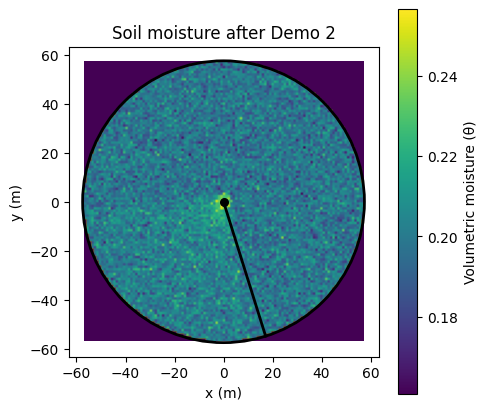

In [6]:
# --- Demo 1: No irrigation, no movement (see ET effect) ---------------------
obs, info = env.reset(seed=0)
print("Start mean moisture:", obs[0])

# action = [angular_speed_cmd, water_rate_cmd]; both in [-1,1]
# Map: speed=0 -> 0 rad/s; rate=-1 -> 0 mm/h
for i in range(100):  # ~100 * 10s = ~16.7 minutes
    obs, r, term, trunc, inf = env.step([0.0, -1.0])
print("After ~16.7 min, mean moisture:", obs[0], "reward last step:", r)

# --- Demo 2: Irrigate and rotate slowly -------------------------------------
obs, info = env.reset(seed=1)
print("\nIrrigation phase start mean:", obs[0])

# speed = +0.3 of max; rate = +0.0 -> 50% of max (i.e., ~20 mm/h)
for i in range(200):  # ~33 minutes
    obs, r, term, trunc, inf = env.step([0.3, 0.0])
print("After ~33 min irrigating, mean:", obs[0], "std:", obs[1])

# Optional: visualize the current moisture map + pivot arm
ax = env.field.plot(title="Soil moisture after Demo 2")
# Overlay moisture as an image instead of just the mask:
import numpy as np
from matplotlib import pyplot as plt
im = ax.imshow(np.where(env.field.mask, env.field.soil_moisture, np.nan),
               origin="lower",
               extent=[env.field.X.min(), env.field.X.max(), env.field.Y.min(), env.field.Y.max()])
env.pivot.plot(ax)
plt.colorbar(im, ax=ax, label="Volumetric moisture (θ)")
plt.show()


In [7]:
# Colab-ready: full-season center-pivot corn simulator (no rain)
# -------------------------------------------------------------
from __future__ import annotations
from dataclasses import dataclass
import numpy as np
import math
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# ====== Constants & helpers ==================================================
HA_IN_M2 = 10_000.0

def diameter_for_area_m2(area_m2: float) -> float:
    r = math.sqrt(area_m2 / math.pi)
    return 2 * r

def area_for_diameter_m(diameter_m: float) -> float:
    r = diameter_m / 2.0
    return math.pi * r * r

# ====== Geometry primitives ==================================================
@dataclass
class Field:
    diameter_m: float
    cell_size_m: float = 1.0

    def __post_init__(self):
        self.radius_m = self.diameter_m / 2.0
        self.area_m2 = area_for_diameter_m(self.diameter_m)
        self.area_ha = self.area_m2 / HA_IN_M2

        side = int(math.ceil(self.diameter_m / self.cell_size_m))
        self.origin_m = -0.5 * side * self.cell_size_m
        xs = np.linspace(self.origin_m + 0.5*self.cell_size_m,
                         -self.origin_m - 0.5*self.cell_size_m,
                         side)
        ys = xs.copy()
        self.X, self.Y = np.meshgrid(xs, ys)
        self.R = np.sqrt(self.X**2 + self.Y**2)
        self.mask = self.R <= self.radius_m + 1e-9

        self.soil_moisture = np.zeros_like(self.R, dtype=np.float32)  # θ (volumetric)
        self.soil_moisture[self.mask] = 0.20  # initial θ (can be changed)

    def plot(self, ax=None, title=""):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(np.where(self.mask, self.soil_moisture, np.nan),
                       origin="lower",
                       extent=[self.X.min(), self.X.max(), self.Y.min(), self.Y.max()])
        circle = plt.Circle((0,0), self.radius_m, fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
        ax.set_title(title or f"Field D={self.diameter_m:.2f} m ({self.area_ha:.3f} ha)")
        plt.colorbar(im, ax=ax, label="Volumetric moisture θ")
        return ax

@dataclass
class CenterPivot:
    radius_m: float               # arm length
    angle_rad: float = 0.0
    angular_speed_rad_s: float = 0.0

    @classmethod
    def from_diameter(cls, diameter_m: float) -> "CenterPivot":
        return cls(radius_m=diameter_m/2.0)

    def tip_position(self):
        return (self.radius_m * math.cos(self.angle_rad),
                self.radius_m * math.sin(self.angle_rad))

    def plot(self, ax, color="k"):
        x_tip, y_tip = self.tip_position()
        ax.plot([0, x_tip], [0, y_tip], linewidth=2, color=color)
        ax.scatter([0], [0], s=30, color=color)

# ====== Season lifecycle (stage manager) ====================================
class CornGrowthCycle:
    """
    Manages stage progression and provides ETc (mm/day) and root depth (m).
    Durations sum to the season length (days). No rain in this model.
    """
    # You can tune these per your climate/hybrid
    STAGES = [
        ("emergence",      10, 3.5, 0.20, 0.2),
        ("vegetative",     25, 4.5, 0.30, 0.4),
        ("rapid_growth",   25, 5.5, 0.35, 0.6),
        ("silking",        20, 7.2, 0.40, 1.0),  # peak
        ("grain_fill",     25, 6.0, 0.40, 0.8),
        ("maturity",       15, 5.0, 0.40, 0.3),
    ]
    # Columns: name, duration_days, ETc_mm_day, root_m, stage_weight

    def __init__(self):
        self.idx = 0
        self.day_in_stage = 0.0
        self._durations = [d for _, d, *_ in self.STAGES]
        self._season_days = sum(self._durations)
        self._cum = np.cumsum([0] + self._durations)

    @property
    def season_days(self) -> int:
        return self._season_days

    def current(self):
        name, dur, etc, root, w = self.STAGES[self.idx]
        frac = np.clip(self.day_in_stage / max(dur, 1e-9), 0, 1)
        return dict(stage=name, duration_days=dur, stage_fraction=frac,
                    etc_mm_day=etc, root_m=root, weight=w, stage_index=self.idx)

    def advance_time_days(self, days: float):
        """Advance the lifecycle clock by 'days' and update stage index."""
        if days <= 0:
            return
        name, dur, etc, root, w = self.STAGES[self.idx]
        self.day_in_stage += days
        while self.day_in_stage >= dur and self.idx < len(self.STAGES)-1:
            self.day_in_stage -= dur
            self.idx += 1
            name, dur, etc, root, w = self.STAGES[self.idx]

    def reset(self):
        self.idx = 0
        self.day_in_stage = 0.0

# ====== Soil parameters: Silt Loam ==========================================
@dataclass
class SoilParams:
    theta_fc: float = 0.32  # field capacity (vol frac)
    theta_wp: float = 0.13  # wilting point
    theta_sat: float = 0.45 # saturation
    k_drain_per_h: float = 0.15  # gravity drainage rate toward θ_fc when θ>θ_fc

# ====== Labeled observation helpers =========================================
OBS_LABELS = [
    "mean θ", "std θ", "min θ", "max θ",
    "sin(angle)", "cos(angle)",
    "stage_idx_norm", "stage_fraction"
]
def obs_to_str(obs: np.ndarray, precision=4):
    vals = [f"{v:.{precision}f}" for v in obs.tolist()]
    return " | ".join(f"{k}: {v}" for k, v in zip(OBS_LABELS, vals))

# ====== Environment ==========================================================
class SeasonPivotEnv(gym.Env):
    """
    Full-season center-pivot irrigation for corn on silt loam (no rain).
    Decision step (e.g., 30 min) contains multiple physics steps (10 s)
    to keep pivot motion realistic without exploding PPO horizons.
    """
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(
        self,
        field: Field,
        pivot: CenterPivot,
        soil: SoilParams = SoilParams(),
        # --- pivot/application ---
        swath_m: float = 3.0,
        rate_max_mm_h: float = 40.0,
        full_rotation_hours: float = 20.0,   # ≈ modern pivot period at max speed
        # --- clocks ---
        dt_phys_s: float = 10.0,             # physics integration step
        dt_ctrl_min: float = 30.0,           # agent decision interval
        # --- lifecycle ---
        cycle: CornGrowthCycle = None,
        season_days: int | None = None,
        # --- reward weights ---
        w_band: float = 3.0,
        w_uneven: float = 1.0,
        w_water: float = 0.10
    ):
        super().__init__()
        self.base_field = field
        self.base_pivot = pivot
        self.soil = soil

        self.swath_m = swath_m
        self.rate_max = rate_max_mm_h
        self.dt_phys = dt_phys_s
        self.dt_ctrl = dt_ctrl_min * 60.0
        self.substeps = int(round(self.dt_ctrl / self.dt_phys))
        self.w_max = 2*math.pi / (full_rotation_hours*3600.0)  # rad/s max

        self.cycle = cycle or CornGrowthCycle()
        if season_days is not None:
            # Optionally override season length by scaling durations
            scale = season_days / self.cycle.season_days
            new = []
            for (name, dur, etc, root, w) in self.cycle.STAGES:
                new.append((name, max(1, int(round(dur*scale))), etc, root, w))
            self.cycle.STAGES = new

        # Action: [angular_speed_cmd, water_rate_cmd] in [-1,1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)

        # Observation: θ summary + angle + stage encodings
        self.num_stages = len(self.cycle.STAGES)
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,-1,-1, 0, 0], dtype=np.float32),
            high=np.array([1,1,1,1, 1, 1, 1, 1], dtype=np.float32),
            shape=(8,),
            dtype=np.float32
        )

        # Internal mutable state
        self.field = None
        self.pivot = None
        self.t_s = 0.0
        self.day_clock = 0.0  # counts control steps → days
        self.episode_days = float(sum(d for _, d, *_ in self.cycle.STAGES))

        # Reward weights
        self.w_band = self.w_band0 = w_band
        self.w_uneven = w_uneven
        self.w_water = w_water

    # ---- High-level process helpers ----------------------------------------
    def _clone_setup(self):
        f = Field(self.base_field.diameter_m, self.base_field.cell_size_m)
        # Start near θ_fc but not uniform (small noise)
        f.soil_moisture[self.base_field.mask] = np.clip(
            np.random.normal(self.soil.theta_fc - 0.02, 0.01, size=self.base_field.mask.sum()),
            0.10, self.soil.theta_sat
        )
        p = CenterPivot(self.base_pivot.radius_m, angle_rad=np.random.uniform(0, 2*np.pi))
        return f, p

    def _current_stage_params(self):
        sc = self.cycle.current()
        return sc["etc_mm_day"], sc["root_m"], sc["stage"], sc["stage_fraction"], sc["weight"], sc["stage_index"]

    def _mmh_to_dtheta(self, mm_h: float, root_m: float) -> float:
        # 1 mm over 1 m^2 = 1 liter per m^2. Convert to volumetric θ change in root zone.
        return (mm_h/1000.0)/max(root_m, 1e-6)

    def _apply_irrigation_swath(self, rate_mm_h: float, root_m: float):
        if rate_mm_h <= 0:
            return
        # Rate per physics step (mm)
        mm_this_step = rate_mm_h * (self.dt_phys / 3600.0)
        dtheta = (mm_this_step/1000.0)/max(root_m, 1e-6)

        # Distance of each cell to arm segment
        x_tip, y_tip = self.pivot.tip_position()
        X, Y = self.field.X, self.field.Y
        P0x, P0y = 0.0, 0.0
        P1x, P1y = x_tip, y_tip
        vx, vy = P1x - P0x, P1y - P0y
        v2 = vx*vx + vy*vy + 1e-12
        wx, wy = X - P0x, Y - P0y
        t = (wx*vx + wy*vy) / v2
        t = np.clip(t, 0.0, 1.0)
        cx = P0x + t*vx
        cy = P0y + t*vy
        dist = np.hypot(X - cx, Y - cy)

        mask = (dist <= self.swath_m) & self.field.mask
        self.field.soil_moisture[mask] = np.clip(
            self.field.soil_moisture[mask] + dtheta, 0.0, self.soil.theta_sat
        )

    def _apply_et_and_percolation(self, etc_mm_day: float, root_m: float):
        # Convert ETc day -> mm per physics step
        mm_step = etc_mm_day * (self.dt_phys / 86400.0)  # mm in this physics slice
        # ET extraction limited by available water above wilting
        m = self.field.soil_moisture
        mask = self.field.mask
        # availability factor: 0 at θ<=θ_wp, 1 at θ>=θ_fc
        avail = np.clip((m - self.soil.theta_wp) / max(self.soil.theta_fc - self.soil.theta_wp, 1e-6), 0.0, 1.0)
        # actual ET in volumetric terms
        dtheta_et = (mm_step/1000.0)/max(root_m, 1e-6) * avail
        m[mask] = np.maximum(0.0, m[mask] - dtheta_et[mask])

        # Gravity drainage when θ>θ_fc toward θ_fc (simple exponential)
        over = np.maximum(0.0, m - self.soil.theta_fc)
        drain = self.soil.k_drain_per_h * (self.dt_phys/3600.0) * over
        m[mask] = np.clip(m[mask] - drain[mask], 0.0, self.soil.theta_sat)

    def _observe(self, stage_idx_norm, stage_frac):
        m = self.field.soil_moisture[self.field.mask]
        s, c = math.sin(self.pivot.angle_rad), math.cos(self.pivot.angle_rad)
        obs = np.array([
            float(m.mean()), float(m.std()), float(m.min()), float(m.max()),
            s, c,
            stage_idx_norm, stage_frac
        ], dtype=np.float32)
        return obs

    def _reward(self, obs, water_rate_mm_h, stage_weight, root_m):
        mean_theta = float(obs[0]); std_theta = float(obs[1])
        # Target band using ~50% depletion trigger (for silt loam: ~38 mm over 0.4 m ≈ Δθ ≈ 0.095)
        # Center target near θ_fc - 0.5*AWC
        awc = (self.soil.theta_fc - self.soil.theta_wp) * root_m  # m water/m^2
        awc_theta = awc / max(root_m, 1e-6)                       # == θ_fc - θ_wp
        target = self.soil.theta_wp + 0.5*awc_theta
        band_half = 0.15 * awc_theta  # ±15% of AWC as comfort band
        low, high = target - band_half, target + band_half

        band_penalty = 0.0
        if mean_theta < low: band_penalty = (low - mean_theta)
        elif mean_theta > high: band_penalty = (mean_theta - high)

        water_penalty = (water_rate_mm_h / max(self.rate_max, 1e-6))  # 0..1 (per control step proxied by last phys step)
        # Stage weight emphasizes critical periods
        r = - (self.w_band*stage_weight*band_penalty + self.w_uneven*std_theta + self.w_water*water_penalty)
        return r

    # ---- Gym API ------------------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        np.random.seed(seed if seed is not None else np.random.randint(0, 1_000_000))
        self.field, self.pivot = self._clone_setup()
        self.cycle.reset()
        self.t_s = 0.0
        self.day_clock = 0.0
        sc = self.cycle.current()
        obs = self._observe(stage_idx_norm=sc["stage_index"]/(len(self.cycle.STAGES)-1),
                            stage_frac=sc["stage_fraction"])
        info = {
            "area_ha": self.field.area_ha,
            "stage": sc["stage"],
            "stage_idx": sc["stage_index"],
            "stage_fraction": sc["stage_fraction"],
            "et_mm_day": sc["etc_mm_day"],
            "root_m": sc["root_m"],
            "sim_seconds": 0.0,
            "sim_day": 0.0,
        }
        return obs, info

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, -1.0, 1.0)
        ang_speed = float(action[0]) * self.w_max
        # Map [-1,1] → [0, rate_max]
        water_rate = float((action[1] + 1.0) * 0.5) * self.rate_max

        etc_mm_day, root_m, name, sfrac, stage_weight, sidx = self._current_stage_params()

        # ---- physics substeps for one control interval ----
        for _ in range(self.substeps):
            # update pivot
            self.pivot.angle_rad = (self.pivot.angle_rad + ang_speed * self.dt_phys) % (2*np.pi)
            # irrigation + ET + percolation
            self._apply_irrigation_swath(water_rate, root_m)
            self._apply_et_and_percolation(etc_mm_day, root_m)
            self.t_s += self.dt_phys

        # advance lifecycle clock by dt_ctrl (in days)
        days_advanced = self.dt_ctrl / 86400.0
        self.day_clock += days_advanced
        self.cycle.advance_time_days(days_advanced)

        # observation
        obs = self._observe(stage_idx_norm=sidx/(self.num_stages-1), stage_frac=sfrac)

        # reward
        reward = self._reward(obs, water_rate, stage_weight, root_m)

        # done flags
        terminated = False
        truncated = (self.day_clock >= self.episode_days)

        # ---- LOGGING: pack everything useful into info ----
        m = self.field.soil_moisture[self.field.mask]
        info = {
            # moisture summary
            "mean_theta": float(m.mean()),
            "std_theta":  float(m.std()),
            "min_theta":  float(m.min()),
            "max_theta":  float(m.max()),
            # stage info
            "stage": name,
            "stage_idx": int(sidx),
            "stage_fraction": float(sfrac),
            "stage_weight": float(stage_weight),
            # controls actually applied over this interval
            "water_rate_mm_h": float(water_rate),
            "ang_speed_rad_s": float(ang_speed),
            # time
            "sim_seconds": float(self.t_s),
            "sim_day": float(self.day_clock),
            # environment constants for reference
            "et_mm_day": float(etc_mm_day),
            "root_m": float(root_m),
        }

        return obs, reward, terminated, truncated, info

    def render(self):
        sc = self.cycle.current()
        obs = self._observe(sc["stage_index"]/(self.num_stages-1), sc["stage_fraction"])
        print(f"t={self.t_s/3600.0:.2f} h | day={self.day_clock:.2f}/{self.episode_days:.0f} "
              f"| stage={sc['stage']} ({100*sc['stage_fraction']:.0f}%) | {obs_to_str(obs)}")


# ====== 🔧 User knobs & env construction ====================================
# Geometry: your 115 m diameter (≈1.039 ha)
diameter_m = 115.0
field = Field(diameter_m=diameter_m, cell_size_m=1.0)
pivot = CenterPivot.from_diameter(diameter_m)

env = SeasonPivotEnv(
    field, pivot,
    soil=SoilParams(theta_fc=0.32, theta_wp=0.13, theta_sat=0.45, k_drain_per_h=0.15),
    swath_m=3.0,
    rate_max_mm_h=40.0,
    full_rotation_hours=20.0,   # ~one revolution per ~20 h at max speed
    dt_phys_s=10.0,
    dt_ctrl_min=30.0,           # PPO decision each 30 minutes
)

# ====== 🧪 Quick smoke test (no training yet) ===============================
obs, info = env.reset(seed=42)
print("Initial:", obs_to_str(obs), "| info:", info)
for i in range(4):
    a = env.action_space.sample()  # random actions
    obs, r, term, trunc, inf = env.step(a)
    print(f"step {i+1}: reward={r:.3f} | {obs_to_str(obs)} | stage={inf['stage']} | done={term or trunc}")

# Optional: visualize current moisture and pivot
# ax = env.field.plot(title=f"Soil moisture (stage: {inf['stage']})")
# env.pivot.plot(ax)
# plt.show()

Initial: mean θ: 0.3000 | std θ: 0.0100 | min θ: 0.2608 | max θ: 0.3393 | sin(angle): 0.4410 | cos(angle): 0.8975 | stage_idx_norm: 0.0000 | stage_fraction: 0.0000 | info: {'area_ha': 1.0386890710931256, 'stage': 'emergence', 'stage_idx': 0, 'stage_fraction': np.float64(0.0), 'et_mm_day': 3.5, 'root_m': 0.2, 'sim_seconds': 0.0, 'sim_day': 0.0}
step 1: reward=-0.081 | mean θ: 0.3010 | std θ: 0.0119 | min θ: 0.2605 | max θ: 0.3662 | sin(angle): 0.3001 | cos(angle): 0.9539 | stage_idx_norm: 0.0000 | stage_fraction: 0.0000 | stage=emergence | done=False
step 2: reward=-0.144 | mean θ: 0.3037 | std θ: 0.0228 | min θ: 0.2603 | max θ: 0.4499 | sin(angle): 0.4199 | cos(angle): 0.9076 | stage_idx_norm: 0.0000 | stage_fraction: 0.0021 | stage=emergence | done=False
step 3: reward=-0.063 | mean θ: 0.3035 | std θ: 0.0225 | min θ: 0.2600 | max θ: 0.4499 | sin(angle): 0.5462 | cos(angle): 0.8376 | stage_idx_norm: 0.0000 | stage_fraction: 0.0042 | stage=emergence | done=False
step 4: reward=-0.103 | 

In [8]:
# Stable-Baselines3 + Gymnasium
!pip -q install "stable-baselines3[extra]" gymnasium==0.29.1

import os, math, numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
qiskit-ibm-runtime 0.36.1 requires pydantic<2.10,>=2.5.0, but you have pydantic 2.11.7 which is incompatible.
vllm 0.10.0 requires setuptools<80,>=77.0.3; python_version > "3.11", but you have setuptools 70.2.0 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# IMPORTANT: assumes SeasonPivotEnv, Field, CenterPivot, SoilParams are already defined in the notebook.

def make_single_env(seed: int = 0):
    def _fn():
        diameter_m = 115.0
        field = Field(diameter_m=diameter_m, cell_size_m=1.0)
        pivot = CenterPivot.from_diameter(diameter_m)
        env = SeasonPivotEnv(
            field, pivot,
            soil=SoilParams(theta_fc=0.32, theta_wp=0.13, theta_sat=0.45, k_drain_per_h=0.15),
            swath_m=3.0,
            rate_max_mm_h=40.0,
            full_rotation_hours=20.0,
            dt_phys_s=10.0,
            dt_ctrl_min=30.0,     # ← PPO acts every 30 min of simulated time
        )
        env = Monitor(env)        # logs episode rewards/lengths
        return env
    return _fn

# Vectorize (you can increase n_envs for faster training if Colab can handle it)
n_envs = 4
vec_env = DummyVecEnv([make_single_env(seed=i) for i in range(n_envs)])

# Normalize observations (and optionally rewards)
vec_env = VecNormalize(
    vec_env,
    training=True,
    norm_obs=True,
    norm_reward=False,  # keep reward in original units to interpret it
    clip_obs=10.0
)

In [10]:
class BriefCallback(BaseCallback):
    def __init__(self, check_freq: int = 50_000, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
    def _on_step(self) -> bool:
        if self.num_timesteps % self.check_freq == 0:
            if self.verbose:
                # Extract episode rewards from the infos list
                # 'infos' is a list of info dicts, one for each parallel environment
                # 'episode' key exists in an info dict only if an episode terminated
                episode_rewards = [info["episode"]["r"] for info in self.locals.get("infos", []) if "episode" in info]
                if episode_rewards:
                    print(f"[{self.num_timesteps:,}] last_ep_rew_mean: {np.mean(episode_rewards):.3f}")
                else:
                    print(f"[{self.num_timesteps:,}] No episode finished in this rollout yet.")
        # basic NaN guard
        if np.isnan(self.model.logger.name_to_value.get("train/loss", 0.0)):
            print("NaN detected in loss; stopping.")
            return False
        return True

callback = BriefCallback(check_freq=100_000, verbose=1)

In [11]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Ti


In [14]:
# PPO hyperparams tuned for long episodes & continuous control
model = PPO(
    "MlpPolicy",
    vec_env,
    device="auto", # cuda for gpu but PPO with MlpPolicy is faster on the CPU according to docs
    verbose=1,
    n_steps=1024,          # default is 2048
    batch_size=256,       # default is 1024 --- large batch helps stability
    n_epochs=4,           # default is 10
    gamma=0.99,           # # default is 0.995
    gae_lambda=0.95,
    learning_rate=3e-4,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    seed=42,
    tensorboard_log="./tb_pivot/",
)

# Training budget (start small, you can scale up)
TIMESTEPS = 50_000 # default is 500_000
model.learn(total_timesteps=TIMESTEPS, callback=callback)

# Save model + normalization stats
os.makedirs("checkpoints", exist_ok=True)
model.save("checkpoints/ppo_pivot_season.zip")
vec_env.save("checkpoints/vecnorm.pkl")
print("Saved to checkpoints/")


Using cuda device
Logging to ./tb_pivot/PPO_4
-----------------------------
| time/              |      |
|    fps             | 23   |
|    iterations      | 1    |
|    time_elapsed    | 178  |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 354         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.004019613 |
|    clip_fraction        | 0.0154      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.0161      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.26        |
|    n_updates            | 4           |
|    policy_gradient_loss | -0.00412    |
|    std                  | 0.999       |
|    value_loss           | 3.

In [15]:
def evaluate_one_season(model, render_every=0):
    # rebuild a fresh eval env with same config but in eval mode
    eval_env = DummyVecEnv([make_single_env(seed=123)])
    eval_env = VecNormalize.load("checkpoints/vecnorm.pkl", eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

    obs = eval_env.reset()
    done = False
    rews = []
    means, stds = [], []
    mins, maxs = [], []
    stages, days = [], []
    water_rates, angles = [], []
    day_clock = 0.0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, infos = eval_env.step(action)
        rews.append(float(reward.mean()))
        o = obs[0]  # de-normalized obs (VecNormalize in eval mode returns normalized; we can track what we need from infos instead)
        # We logged a lot of stuff in env.info; grab from infos[0]
        info = infos[0]
        means.append(info.get("mean_theta", np.nan) if "mean_theta" in info else np.nan)
        stds.append(info.get("std_theta", np.nan) if "std_theta" in info else np.nan)
        mins.append(info.get("min_theta", np.nan) if "min_theta" in info else np.nan)
        maxs.append(info.get("max_theta", np.nan) if "max_theta" in info else np.nan)
        stages.append(info.get("stage", ""))
        water_rates.append(info.get("water_rate_mm_h", np.nan))
        angles.append(info.get("ang_speed_rad_s", np.nan))

        day_clock += (30.0/60.0/24.0)  # each step == 30 min == 1/48 day
        days.append(day_clock)

        if done.any():
            break

    return {
        "rewards": np.array(rews),
        "mean": np.array(means),
        "std": np.array(stds),
        "min": np.array(mins),
        "max": np.array(maxs),
        "stage": np.array(stages, dtype=object),
        "water_rate": np.array(water_rates),
        "ang_speed": np.array(angles),
        "days": np.array(days),
    }

# NOTE: our env didn't yet put mean/std/min/max into info; let's quickly add that hook.
# Go back to SeasonPivotEnv.step() and, right before 'return', append:
#   m = self.field.soil_moisture[self.field.mask]
#   info.update({
#       "mean_theta": float(m.mean()),
#       "std_theta": float(m.std()),
#       "min_theta": float(m.min()),
#       "max_theta": float(m.max()),
#   })
# Re-run the cell defining SeasonPivotEnv if you add this.


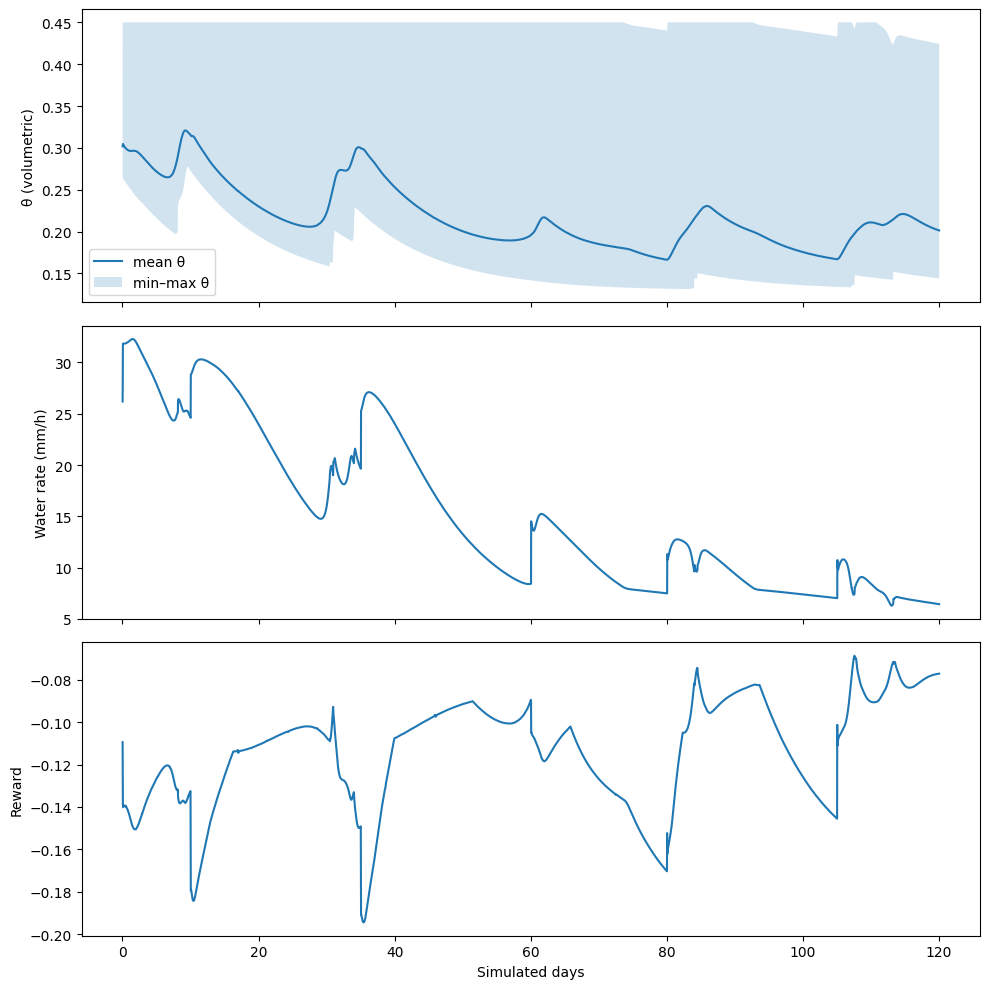

In [16]:
res = evaluate_one_season(model)

days = res["days"]
fig, ax = plt.subplots(3,1, figsize=(10,10), sharex=True)

ax[0].plot(days, res["mean"], label="mean θ")
ax[0].fill_between(days, res["min"], res["max"], alpha=0.2, label="min–max θ")
ax[0].set_ylabel("θ (volumetric)")
ax[0].legend(loc="best")

ax[1].plot(days, res["water_rate"])
ax[1].set_ylabel("Water rate (mm/h)")

ax[2].plot(days, res["rewards"])
ax[2].set_ylabel("Reward")
ax[2].set_xlabel("Simulated days")

plt.tight_layout()
plt.show()


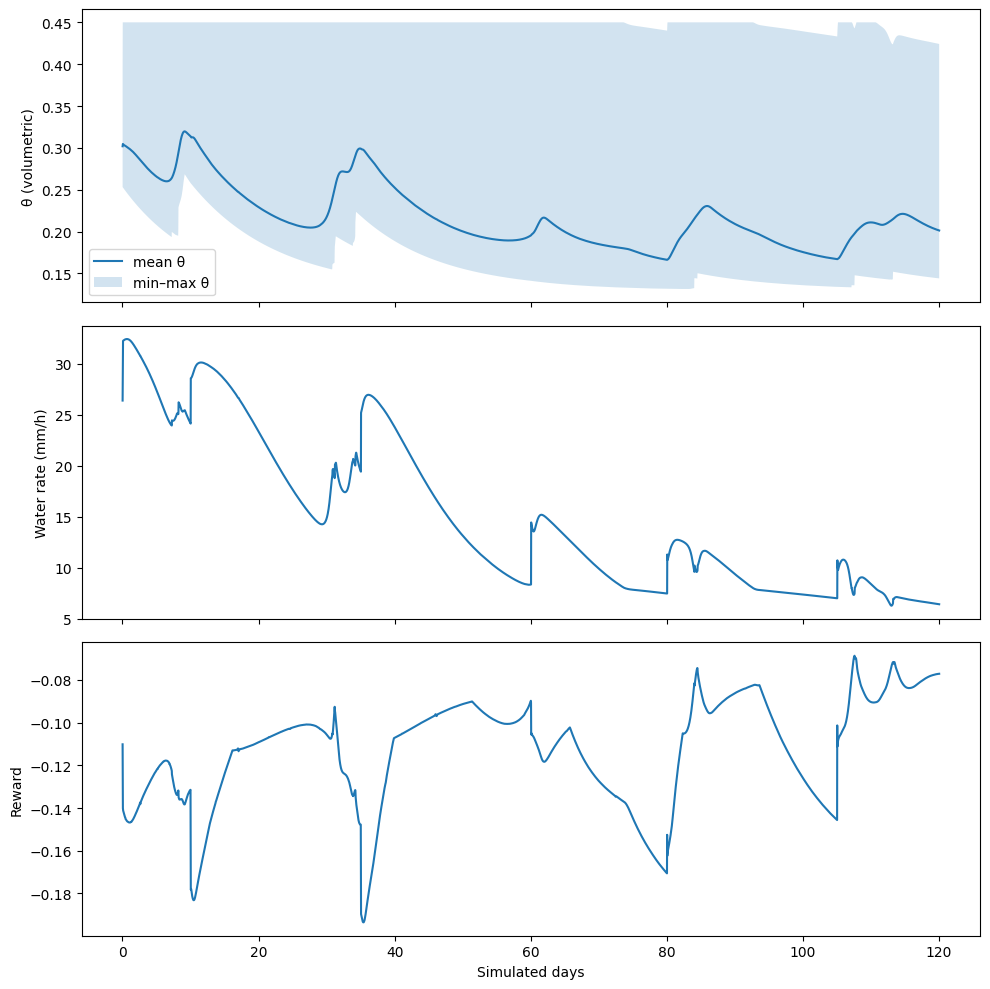

Season summary:
  Steps: 5761
  θ mean (min/avg/max): 0.166 / 0.218 / 0.320
  Total irrigation (mm·h proxy): ~1795.6 (rate integrated over days)


C:\Users\marua\AppData\Local\Temp\ipykernel_46132\875744177.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"  Total irrigation (mm·h proxy): ~{np.trapz(res['water_rate'], res['days']):.1f} (rate integrated over days)")


In [17]:
# ===== Step 2 — Simple Evaluation (one full season, no training) ============
import os, numpy as np, matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Reuse your factory from Step 1 (or define it quickly here)
def make_single_env(seed: int = 123):
    def _fn():
        diameter_m = 115.0
        field = Field(diameter_m=diameter_m, cell_size_m=1.0)
        pivot = CenterPivot.from_diameter(diameter_m)
        env = SeasonPivotEnv(
            field, pivot,
            soil=SoilParams(theta_fc=0.32, theta_wp=0.13, theta_sat=0.45, k_drain_per_h=0.15),
            swath_m=3.0,
            rate_max_mm_h=40.0,
            full_rotation_hours=20.0,
            dt_phys_s=10.0,
            dt_ctrl_min=30.0,    # 30-min control step
        )
        return env
    return _fn

def build_eval_env(seed=123):
    """Build a single-env VecEnv and load VecNormalize stats if they exist."""
    venv = DummyVecEnv([make_single_env(seed=seed)])
    if os.path.exists("checkpoints/vecnorm.pkl"):
        venv = VecNormalize.load("checkpoints/vecnorm.pkl", venv)
        venv.training = False
        venv.norm_reward = False
    return venv

def evaluate_one_season(policy="model", deterministic=True, seed=123):
    """
    Runs one whole season using:
      - policy='model' -> uses `model.predict(...)` if a global `model` exists
      - policy='random' -> random actions (baseline placeholder for step 3)
    Returns a dict of arrays and also makes 3 plots.
    """
    env = build_eval_env(seed=seed)
    obs = env.reset()
    done = np.array([False])
    rewards = []
    days = []
    mean_t, std_t, min_t, max_t = [], [], [], []
    rates, ang_speeds, stages = [], [], []

    # Derive days-per-step from env (30 min default)
    # We can infer from logged info after first step, but we know it's 1/48 day.
    day_per_step = 1.0 / 48.0

    while True:
        if policy == "model" and "model" in globals():
            action, _ = model.predict(obs, deterministic=deterministic)
        else:
            action = env.action_space.sample()

        obs, rew, done, infos = env.step(action)
        info = infos[0]
        rewards.append(float(rew.mean()))
        mean_t.append(info["mean_theta"])
        std_t.append(info["std_theta"])
        min_t.append(info["min_theta"])
        max_t.append(info["max_theta"])
        rates.append(info["water_rate_mm_h"])
        ang_speeds.append(info["ang_speed_rad_s"])
        stages.append(info["stage"])
        # Use sim_day if present (more robust), otherwise accumulate
        if "sim_day" in info:
            days.append(info["sim_day"])
        else:
            days.append((days[-1] + day_per_step) if days else 0.0)

        if done.any():
            break

    # --------- Plots ----------
    days_np = np.array(days)
    fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # Soil moisture
    ax[0].plot(days_np, mean_t, label="mean θ")
    ax[0].fill_between(days_np, min_t, max_t, alpha=0.20, label="min–max θ")
    ax[0].set_ylabel("θ (volumetric)")
    ax[0].legend(loc="best")

    # Water rate
    ax[1].plot(days_np, rates)
    ax[1].set_ylabel("Water rate (mm/h)")

    # Reward
    ax[2].plot(days_np, rewards)
    ax[2].set_ylabel("Reward")
    ax[2].set_xlabel("Simulated days")

    plt.tight_layout()
    plt.show()

    return {
        "days": days_np,
        "reward": np.array(rewards),
        "mean": np.array(mean_t),
        "std": np.array(std_t),
        "min": np.array(min_t),
        "max": np.array(max_t),
        "water_rate": np.array(rates),
        "ang_speed": np.array(ang_speeds),
        "stage": np.array(stages, dtype=object),
    }

# === Run the evaluation ===
# If you trained PPO earlier and have `model` + checkpoints/vecnorm.pkl, it will use them.
# Otherwise it falls back to random actions (useful just to test plots).
res = evaluate_one_season(policy="model", deterministic=True, seed=123)

print("Season summary:")
print(f"  Steps: {len(res['days'])}")
print(f"  θ mean (min/avg/max): {res['mean'].min():.3f} / {res['mean'].mean():.3f} / {res['mean'].max():.3f}")
print(f"  Total irrigation (mm·h proxy): ~{np.trapz(res['water_rate'], res['days']):.1f} (rate integrated over days)")